In [95]:
import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import expit, logit
import numpy as np
from tqdm import tqdm
import numpyro
import numpyro.distributions as dist
import src.Aux_functions as aux
from itertools import combinations
import matplotlib.pyplot as plt 



In [58]:
key = random.PRNGKey(0)

# Generate some data
n = 500
triu_dim = n*(n-1)//2

x = random.normal(key, shape=(n,))*3
x2 = random.binomial(key, n=1, p=0.1, shape=(n,))
idx_pairs = list(combinations(range(len(x)), 2))
x_diff = jnp.array([abs(x[i] - x[j]) for i, j in idx_pairs])
x2_or = jnp.array([1 if (x2[i] + x2[j] == 1) else 0 for i, j in idx_pairs])


print(x.shape, x2.shape, x_diff.shape, x2_or.shape)

# Network data

df_edges = jnp.transpose(jnp.stack([x_diff, x2_or]))
theta = jnp.array([-2, 1.5])
gamma = jnp.array([1.1, 0.2, -1, 1])

triu_star_probs = expit(jnp.dot(df_edges, theta))
triu_star = random.binomial(key, n=1, p=triu_star_probs, shape=(triu_dim,))


triu_obs_probs = expit((triu_star * gamma[0]) + (1 - triu_star) * (gamma[1] + jnp.dot(df_edges, gamma[2:])))
triu_obs = random.binomial(key, n=1, p=triu_obs_probs, shape=(triu_dim,))

print(triu_star.shape, triu_obs.shape)

# Outcome data

mat_star = aux.Triu_to_mat(triu_star)
Z = random.binomial(key, n=1, p=0.5, shape=(n,))
exposures = jnp.dot(mat_star, Z)

df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, x, exposures]))
eta = jnp.array([-1, 3, -0.25, 3])

mean_y = jnp.dot(df_nodes, eta)
sig_y = 1

Y = random.normal(key, shape=(n,))*sig_y + mean_y

print(Y.shape)



(500,) (500,) (124750,) (124750,)
(124750,) (124750,)
(500,)


In [17]:
print(triu_star[1:5], "\n", triu_obs[1:5])

[0. 0. 0. 1.] 
 [1. 0. 0. 1.]


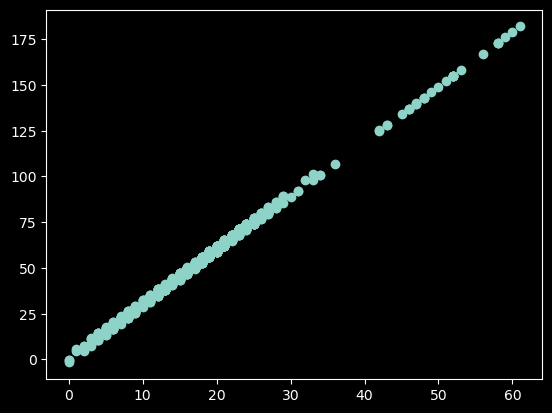

In [74]:
plt.scatter(exposures, Y)

In [84]:
@jax.jit
def A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta):
    logits_a_star = jnp.dot(df_edges, theta)
    a_star_log_likelihood = triu_star * (-jnp.log1p(jnp.exp(-logits_a_star))) + (1 - triu_star) * (-jnp.log1p(jnp.exp(logits_a_star)))

    logits_a_obs = (triu_star * gamma[0]) + (1 - triu_star) * (gamma[1] + jnp.dot(df_edges, gamma[2:]))
    a_obs_log_likelihood = triu_obs * (-jnp.log1p(jnp.exp(-logits_a_obs))) + (1 - triu_obs) * (-jnp.log1p(jnp.exp(logits_a_obs)))


    # curr_a_star = aux.Triu_to_mat(triu_star)
    # exposures = jnp.dot(curr_a_star, Z)
    # df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, exposures]))
    # mean_y = jnp.dot(df_nodes, eta)
    # y_log_likelihood = - jnp.sum((Y - mean_y)**2)
    y_log_likelihood = 0
    # TODO: need to check why adding the outcome makes the likelihood (and gradients) act weird
    # TODO: probably need to consider which units are affected by each A*_{ij} and their outcome probs to the likelihood

    log_prob = a_star_log_likelihood + a_obs_log_likelihood + y_log_likelihood
    log_prob_sum = jnp.sum(log_prob)

    # return jnp.sum(a_star_log_likelihood) + jnp.sum(a_obs_log_likelihood) + y_log_likelihood
    return log_prob_sum, log_prob

In [85]:
print(A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta))

(Array(-60142.33, dtype=float32), Array([-0.48001826, -2.3502064 , -0.01477553, ..., -0.46822965,
       -0.12236725, -3.2227528 ], dtype=float32))


(124750,) (124750,)
-60142.33 
 [ -1.8626964  -8.911947  -12.396516    1.1397066  -6.0584917  -8.6966505
  -6.223612   -8.753494  -11.499445 ]


(array([1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 6.000e+00,
        4.000e+00, 5.000e+00, 6.000e+00, 8.000e+00, 6.000e+00, 3.000e+00,
        9.000e+00, 4.000e+00, 8.000e+00, 1.000e+01, 8.000e+00, 1.700e+01,
        1.400e+01, 1.800e+01, 1.600e+01, 1.800e+01, 2.700e+01, 2.900e+01,
        2.400e+01, 4.200e+01, 4.600e+01, 5.900e+01, 6.200e+01, 9.400e+01,
        8.500e+01, 1.040e+02, 1.340e+02, 1.310e+02, 1.670e+02, 1.710e+02,
        1.960e+02, 2.490e+02, 2.530e+02, 3.010e+02, 3.440e+02, 4.030e+02,
        3.860e+02, 4.760e+02, 5.200e+02, 5.900e+02, 6.130e+02, 6.700e+02,
        7.860e+02, 8.270e+02, 9.180e+02, 1.006e+03, 1.114e+03, 1.194e+03,
        1.250e+03, 1.297e+03, 1.441e+03, 1.536e+03, 1.635e+03, 1.796e+03,
        1.915e+03, 1.958e+03, 2.173e+03, 2.209e+03, 2.363e+03, 2.508e+03,
        2.525e+03, 2.824e+03, 2.873e+03, 2.981e+03, 3.185e+03, 3.242e+03,
        3.403e+03, 3.509e+03, 3.712e+0

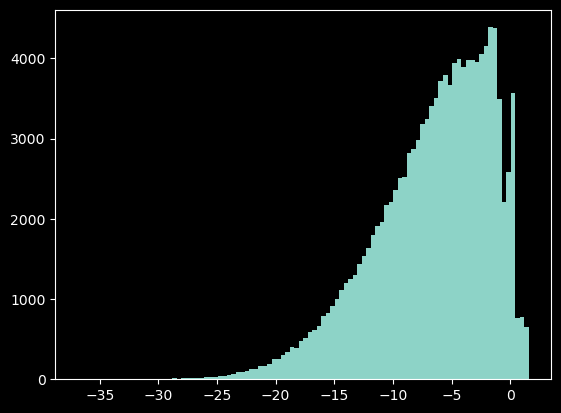

In [86]:
val_grad_fn = jax.value_and_grad(A_star_cond_log_post, argnums=0, has_aux=True) 

(sum_logprob, log_prob), gradient = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta)

print(log_prob.shape, gradient.shape)
print(sum_logprob, "\n", gradient[1:10])

# create histogram of gradient

plt.hist(gradient, bins=100)

In [97]:
# create a function that `flip` triu_star value (0->1, 1->0), each at a time
#  and for each flip compute difference in log prob (sum)

@jax.jit
def flip_triu_star(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta, idx):
    new_triu_star = triu_star.at[idx].set(1 - triu_star[idx])
    log_prob_sum, _ = A_star_cond_log_post(new_triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta)
    return log_prob_sum

# now wrap for all idx

@jax.jit
def flip_triu_star_all(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta):
    return jnp.array([flip_triu_star(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta, idx) for idx in range(len(triu_star))])

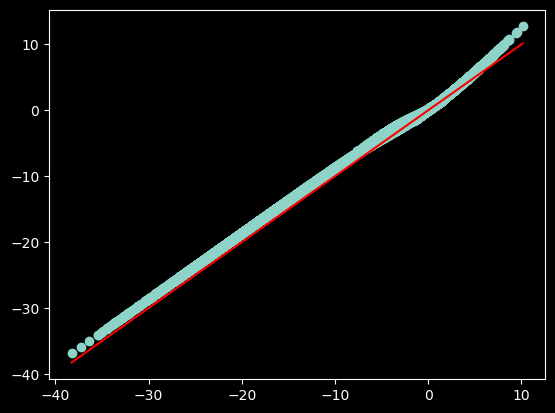

In [88]:
#  manual diff

_, f_a = A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta)
_, f_a_tag = A_star_cond_log_post(1-triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta)

grad_manual = f_a_tag - f_a

# score_grad = jnp.sum(-(2*triu_star-1)*gradient)
score_grad = -(2*triu_star-1)*gradient

# plt.hist(score_grad, bins=100)
plt.scatter(grad_manual, score_grad)
#  add y~x line
plt.plot([min(grad_manual), max(grad_manual)], [min(grad_manual), max(grad_manual)], color='red')
# plt.hist(grad_manual - score_grad, bins=100)

In [96]:
# compare jax grad with manual grad running time by changing theta[0] values 

import time 

start = time.time()
for theta_0 in tqdm(jnp.arange(-3, -1, 0.001), desc = "jax grad"):
    c_theta = jnp.array([theta_0, 1.5])
    (_, _), gradient = val_grad_fn(triu_star, triu_obs, df_edges, c_theta, gamma, Y, x, Z, eta)

print("jax time: ", time.time() - start)

start = time.time()
for theta_0 in tqdm(jnp.arange(-3, -1, 0.001), desc = "manual grad"):
    c_theta = np.array([theta_0, 1.5])
    _, f_a = A_star_cond_log_post(triu_star, triu_obs, df_edges, c_theta, gamma, Y, x, Z, eta)
    _, f_a_tag = A_star_cond_log_post(1-triu_star, triu_obs, df_edges, c_theta, gamma, Y, x, Z, eta)
    grad_manual = f_a_tag - f_a

print("manual time: ", time.time() - start)



jax grad: 100%|██████████| 2000/2000 [00:11<00:00, 176.47it/s]


jax time:  11.409334897994995


manual grad: 100%|██████████| 2000/2000 [00:12<00:00, 162.62it/s]

manual time:  12.29876184463501


In [93]:
print(len(range(-3.,-1.,.1)))

TypeError: 'float' object cannot be interpreted as an integer